In [1]:
%matplotlib widget

In [2]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

In [3]:
from microscope_calibration.common.model import Parameters4DSTEM, Model4DSTEM, Result4DSTEM, PixelYX
from microscope_calibration.util.stem_overfocus_sim import smiley, project

In [4]:
size = 16
params = Parameters4DSTEM(
    overfocus=0.0001,
    scan_pixel_pitch=0.000001,
    camera_length=1,
    detector_pixel_pitch=0.001,
    semiconv=0.4,
    scan_center=PixelYX(x=0.1, y=0.1),
    scan_rotation=0,
    flip_y=False,
    detector_center=PixelYX(x=0.1, y=0.1),
)

test_parameters = np.array((
    [0., 0., 0., 0.],
    [1., 0., 0., 0.],
    [0., 1., 0., 0.],
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [1., 1., 1., 1.],
    [1., 2., 3., 4.],
))

input_samples = []
output_samples = []



def record(res: Result4DSTEM, scan_pos: PixelYX, source_dy: float, source_dx: float, input_samples: list, output_samples: list):
    input_sample = (
        scan_pos.y,
        scan_pos.x,
        res['detector'].sampling['detector_px'].y,
        res['detector'].sampling['detector_px'].x,
        1.
    )
    output_sample = (
        res['specimen'].sampling['scan_px'].y,
        res['specimen'].sampling['scan_px'].x,
        source_dy,
        source_dx,
        1.,
    )
    output_samples.append(output_sample)
    input_samples.append(input_sample)

for test_param_raw in test_parameters:
    for fact in (1., 2.):
        test_param = test_param_raw * fact
        scan_pos = PixelYX(x=test_param[0], y=test_param[1])
        source_dy = test_param[2]
        source_dx = test_param[3]
        model = Model4DSTEM.build(params=params, scan_pos=scan_pos)
        ray = model.make_source_ray(source_dy=source_dy, source_dx=source_dx).ray
        res = model.trace(ray)
        record(
            res=res,
            scan_pos=scan_pos,
            source_dx=source_dx,
            source_dy=source_dy,
            input_samples=input_samples,
            output_samples=output_samples
        )

In [5]:
np.array(input_samples), np.array(output_samples)

(array([[0.00000000e+00, 0.00000000e+00, 1.00000001e-01, 1.00000001e-01,
         1.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000001e-01, 1.00000001e-01,
         1.00000000e+00],
        [0.00000000e+00, 1.00000000e+00, 1.00000001e-01, 1.00000001e-01,
         1.00000000e+00],
        [0.00000000e+00, 2.00000000e+00, 1.00000001e-01, 1.00000001e-01,
         1.00000000e+00],
        [1.00000000e+00, 0.00000000e+00, 1.00000001e-01, 1.00000001e-01,
         1.00000000e+00],
        [2.00000000e+00, 0.00000000e+00, 1.00000001e-01, 1.00000001e-01,
         1.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00019995e+03, 1.00000001e-01,
         1.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.00029993e+03, 1.00000001e-01,
         1.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000001e-01, 1.00019995e+03,
         1.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000001e-01, 2.00029993e+03,
         1.00000000e+00],
        [1

In [7]:
x, residuals, rank, s = np.linalg.lstsq(np.array(input_samples), np.array(output_samples))

print(residuals, s)

assert len(residuals) == rank
assert np.allclose(np.sum(residuals), 0.)
assert rank == 5

for i in range(len(input_samples)):
    # print(output_samples[i] - input_samples[i] @ x)
    assert np.allclose(
        output_samples[i],
        input_samples[i] @ x,
        rtol=1e-6,
        atol=1e-6
    )
x, s

[6.60496612e-10 9.85655386e-11 2.23490100e-15 7.44949936e-15
 5.18460341e-31] [1.18257819e+04 2.27739159e+03 3.70943468e+00 2.33512951e+00
 2.23606797e+00]


AssertionError: 

In [8]:
obj = smiley(size)
projected_ref = np.zeros((size, size, size, size))

for scan_y in range(size):
    for scan_x in range(size):
        for det_y in range(size):
            for det_x in range(size):
                inp = np.array((scan_y, scan_x, det_y, det_x, 1.))
                spec_y, spec_x, tilt_y, tilt_x, _one = inp @ x
                assert np.allclose(_one, 1)
                if np.linalg.norm((tilt_y, tilt_x)) < model.source.semi_conv:
                    spec_y = int(np.round(spec_y))
                    spec_x = int(np.round(spec_x))
                    if spec_y >= 0 and spec_y < size and spec_x >= 0 and spec_x < size:
                        projected_ref[scan_y, scan_x, det_y, det_x] = obj[spec_y, spec_x]

In [9]:
projected = np.zeros((size, size, size, size))

limit = np.abs(model.source.semi_conv)**2

@numba.njit
def project_frame_forward(obj, mat, scan_y, scan_x, out):
    for det_y in range(out.shape[0]):
        for det_x in range(out.shape[1]):
            #_one = scan_y * mat[0, 4] + scan_x * mat[1, 4] + det_y * mat[2, 4] + det_x * mat[3, 4] + mat[4, 4]
            #assert np.allclose(_one, 1)
            tilt_y = scan_y * mat[0, 2] + scan_x * mat[1, 2] + det_y * mat[2, 2] + det_x * mat[3, 2] + mat[4, 2]
            tilt_x = scan_y * mat[0, 3] + scan_x * mat[1, 3] + det_y * mat[2, 3] + det_x * mat[3, 3] + mat[4, 3]
            if np.abs(tilt_y)**2 + np.abs(tilt_x)**2 < limit:
                spec_y = scan_y * mat[0, 0] + scan_x * mat[1, 0] + det_y * mat[2, 0] + det_x * mat[3, 0] + mat[4, 0]
                spec_x = scan_y * mat[0, 1] + scan_x * mat[1, 1] + det_y * mat[2, 1] + det_x * mat[3, 1] + mat[4, 1]
                spec_y = int(np.round(spec_y))
                spec_x = int(np.round(spec_x))
                if spec_y >= 0 and spec_y < size and spec_x >= 0 and spec_x < size:
                    out[det_y, det_x] = obj[spec_y, spec_x]



In [10]:
for scan_y in range(projected.shape[0]):
    for scan_x in range(projected.shape[1]):
        project_frame_forward(
            obj=obj,
            mat=x,
            scan_y=scan_y,
            scan_x=scan_x,
            out=projected[scan_y, scan_x]
        )

524 μs ± 1.63 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
462 μs ± 1.63 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
327 μs ± 877 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

In [11]:
np.allclose(projected, projected_ref)

True

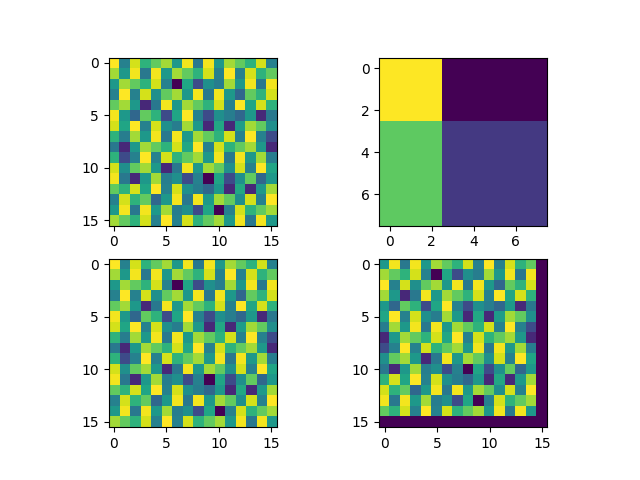

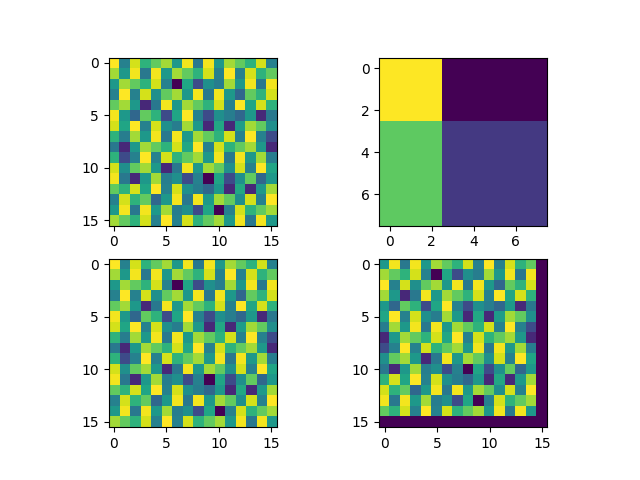

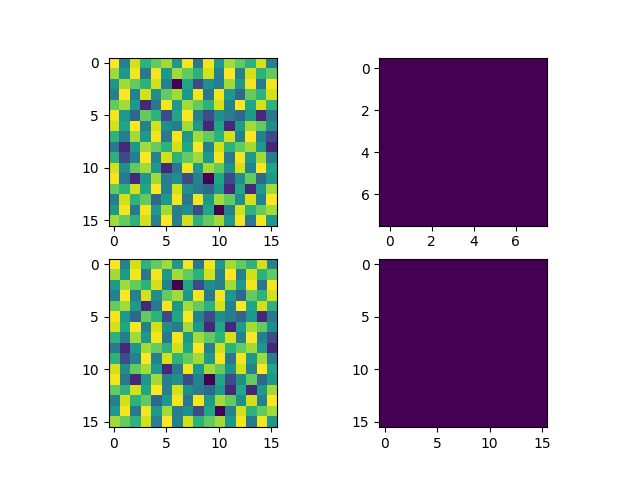

In [12]:
fig, axes = plt.subplots(2, 2)

axes[0, 0].imshow(obj)
axes[0, 1].imshow(projected[size//2, size//2, ::2, ::2])
axes[1, 0].imshow(obj)
axes[1, 1].imshow(projected[:, :, size//2, size//2])

fig, axes = plt.subplots(2, 2)

axes[0, 0].imshow(obj)
axes[0, 1].imshow(projected_ref[size//2, size//2, ::2, ::2])
axes[1, 0].imshow(obj)
axes[1, 1].imshow(projected_ref[:, :, size//2, size//2])

fig, axes = plt.subplots(2, 2)

axes[0, 0].imshow(obj)
axes[0, 1].imshow((projected-projected_ref)[size//2, size//2, ::2, ::2])
axes[1, 0].imshow(obj)
axes[1, 1].imshow((projected-projected_ref)[:, :, size//2, size//2])

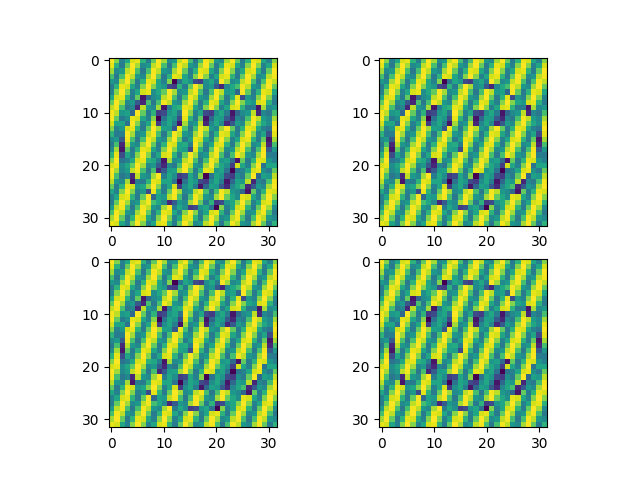

In [21]:
params = Parameters4DSTEM(
    overfocus=1,
    scan_pixel_pitch=1,
    camera_length=1,
    detector_pixel_pitch=2,
    semiconv=np.inf,
    scan_center=PixelYX(x=16., y=16.),
    scan_rotation=0.,
    flip_y=False,
    detector_center=PixelYX(x=16, y=16),
)
obj = smiley(32)
projected = project(
    image=obj,
    detector_shape=(32, 32),
    scan_shape=(32, 32),
    sim_params=params,
)

fig, axes = plt.subplots(2, 2)

axes[0, 0].imshow(obj)
axes[0, 1].imshow(projected[16, 16, :, :])
axes[1, 0].imshow(obj)
axes[1, 1].imshow(projected[:, :, size*2//2, size*2//2])


In [ ]:
p = OverfocusParams(
    overfocus=1,
    scan_pixel_size=1,
    camera_length=1,
    detector_pixel_size=1,
    cy=0,
    cx=0,
)
p	

In [ ]:
detector_px_to_specimen_px(
    y_px=1.,
    x_px=0.,
    fov_size_y=0,
    fov_size_x=0,
    transformation_matrix=np.array(((0., 1.), (1., 0.))),
    **p
)

In [ ]:
%autoreload
size = 32
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=size/2,
    cx=size/2,
    scan_rotation=0,
    flip_y=False
)
obj = smiley(size)
projected = project(
    image=obj,
    scan_shape=(size, size),
    detector_shape=(size, size),
    sim_params=params,
)

In [ ]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(obj)
axes[1].imshow(projected[:, :, size//2, size//2])
axes[2].imshow(projected[:, :, size//2, size//2] - obj)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(obj)
axes[1].imshow(projected[size//2, size//2, :])
axes[2].imshow(projected[size//2, size//2, :] - obj)

In [ ]:
%autoreload
size = 32
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=size/2,
    cx=size/2,
    scan_rotation=0,
    flip_y=False
)
obj = np.zeros((size, size))
obj[size//2, size//2] = 1
sim = project(obj, scan_shape=(size, size), detector_shape=(size, size), sim_params=params)
assert sim[size//2, size//2, size//2, size//2] == 1

udf = OverfocusUDF(params)
ctx = Context.make_with('inline')
ds = ctx.load('memory', data=sim)

res = ctx.run_udf(dataset=ds, udf=udf, plots=True)

res['point']

In [ ]:
fig, axes = plt.subplots()
axes.imshow(sim[size//2, size//2])

In [ ]:
fig, axes = plt.subplots()
axes.imshow(sim[:, :, size//2 + 1, size//2 + 1])

In [ ]:
def get_translation_matrix(params: OverfocusParams, nav_shape):
    a = []
    b = []

    for det_y in (-10, 10):
        for det_x in (-10, 10):
            spec_y, spec_x = detector_px_to_specimen_px(
                y_px=float(det_y),
                x_px=float(det_x),
                fov_size_y=float(nav_shape[0]),
                fov_size_x=float(nav_shape[1]),
                transformation_matrix=get_transformation_matrix(params),
                cy=params['cy'],
                cx=params['cx'],
                detector_pixel_size=float(params['detector_pixel_size']),
                scan_pixel_size=float(params['scan_pixel_size']),
                camera_length=float(params['camera_length']),
                overfocus=float(params['overfocus']),
            )
            for scan_y in (-10, 10):
                for scan_x in (-10, 10):                    
                    offset_y = scan_y - nav_shape[0] / 2
                    offset_x = scan_x - nav_shape[1] / 2
                    image_px_y = spec_y + offset_y
                    image_px_x = spec_x + offset_x
                    a.append((
                        image_px_y,
                        image_px_x,
                        scan_y,
                        scan_x,
                        1
                    ))
                    b.append((det_y, det_x))
    #print(a)
    #print(b)
    res = np.linalg.lstsq(a, b, rcond=None)
    return res[0]

In [ ]:
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=size/2,
    cx=size/2,
    scan_rotation=0,
    flip_y=False
)

get_translation_matrix(params, nav_shape=(32, 32))

In [ ]:
class RefOverfocusUDF(OverfocusUDF):
    def get_task_data(self):
        overfocus_params = self.params.overfocus_params
        translation_matrix = get_translation_matrix(
            params=overfocus_params,
            nav_shape=self._get_fov()
        )
        select_roi = np.zeros(self.meta.dataset_shape.nav, dtype=bool)
        nav_y, nav_x = self.meta.dataset_shape.nav
        select_roi[nav_y//2, nav_x//2] = True
        return {
            'translation_matrix': translation_matrix,
            'select_roi': select_roi
        }

In [ ]:
%autoreload
size = 16
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=size/2,
    cx=size/2,
    scan_rotation=0,
    flip_y=False
)
obj = np.zeros((size, size))
obj[size//2, size//2] = 1
sim = project(obj, scan_shape=(size, size), detector_shape=(size, size), sim_params=params)
assert sim[size//2, size//2, size//2, size//2] == 1

ref_udf = RefOverfocusUDF(params)
res_udf = OverfocusUDF(params)
ctx = Context.make_with('inline')
ds = ctx.load('memory', data=sim)

res = ctx.run_udf(dataset=ds, udf=(ref_udf, res_udf), plots=True)

In [ ]:
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=4.,
    cx=4.,
    scan_rotation=0,
    flip_y=False
)
obj = np.zeros((8, 8))
obj[4, 4] = 1
sim = project(obj, scan_shape=(8, 8), detector_shape=(8, 8), sim_params=params)
assert sim[4, 4, 4, 4] == 1

ctx = Context.make_with('inline')
ds = ctx.load('memory', data=sim)

ref_udf = RefOverfocusUDF(params)
res_udf = OverfocusUDF(params)

res = ctx.run_udf(dataset=ds, udf=(ref_udf, res_udf), plots=True)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(res[0]['shifted_sum'].data.astype(bool))
axes[1].imshow(obj.astype(bool))
